##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Recurrent Neural Networks (RNN) with Keras

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/keras/rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/snapshot-keras/site/en/guide/keras/rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/keras-team/keras-io/blob/master/guides/working_with_rnns.py"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/guide/keras/rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Introduction

Recurrent neural networks (RNN) are a class of neural networks that is powerful for
modeling sequence data such as time series or natural language.

Schematically, a RNN layer uses a `for` loop to iterate over the timesteps of a
sequence, while maintaining an internal state that encodes information about the
timesteps it has seen so far.

The Keras RNN API is designed with a focus on:

- **Ease of use**: the built-in `keras.layers.RNN`, `keras.layers.LSTM`,
`keras.layers.GRU` layers enable you to quickly build recurrent models without
having to make difficult configuration choices.

- **Ease of customization**: You can also define your own RNN cell layer (the inner
part of the `for` loop) with custom behavior, and use it with the generic
`keras.layers.RNN` layer (the `for` loop itself). This allows you to quickly
prototype different research ideas in a flexible way with minimal code.

## Setup

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Built-in RNN layers: a simple example

There are three built-in RNN layers in Keras:

1. `keras.layers.SimpleRNN`, a fully-connected RNN where the output from previous
timestep is to be fed to next timestep.

2. `keras.layers.GRU`, first proposed in
[Cho et al., 2014](https://arxiv.org/abs/1406.1078).

3. `keras.layers.LSTM`, first proposed in
[Hochreiter & Schmidhuber, 1997](https://www.bioinf.jku.at/publications/older/2604.pdf).

In early 2015, Keras had the first reusable open-source Python implementations of LSTM
and GRU.

Here is a simple example of a `Sequential` model that processes sequences of integers,
embeds each integer into a 64-dimensional vector, then processes the sequence of
vectors using a `LSTM` layer.

In [3]:
model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128))

# Add a Dense layer with 10 units.
model.add(layers.Dense(10))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 164,106
Trainable params: 164,106
Non-trainable params: 0
_________________________________________________________________


Built-in RNNs support a number of useful features:

- Recurrent dropout, via the `dropout` and `recurrent_dropout` arguments
- Ability to process an input sequence in reverse, via the `go_backwards` argument
- Loop unrolling (which can lead to a large speedup when processing short sequences on
CPU), via the `unroll` argument
- ...and more.

For more information, see the
[RNN API documentation](https://keras.io/api/layers/recurrent_layers/).

## Outputs and states

By default, the output of a RNN layer contains a single vector per sample. This vector
is the RNN cell output corresponding to the last timestep, containing information
about the entire input sequence. The shape of this output is `(batch_size, units)`
where `units` corresponds to the `units` argument passed to the layer's constructor.

A RNN layer can also return the entire sequence of outputs for each sample (one vector
per timestep per sample), if you set `return_sequences=True`. The shape of this output
is `(batch_size, timesteps, units)`.

In [4]:
model = keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model.add(layers.GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(layers.SimpleRNN(128))

model.add(layers.Dense(10))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
gru (GRU)                    (None, None, 256)         247296    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               49280     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 361,866
Trainable params: 361,866
Non-trainable params: 0
_________________________________________________________________


In addition, a RNN layer can return its final internal state(s). The returned states
can be used to resume the RNN execution later, or
[to initialize another RNN](https://arxiv.org/abs/1409.3215).
This setting is commonly used in the
encoder-decoder sequence-to-sequence model, where the encoder final state is used as
the initial state of the decoder.

To configure a RNN layer to return its internal state, set the `return_state` parameter
to `True` when creating the layer. Note that `LSTM` has 2 state  tensors, but `GRU`
only has one.

To configure the initial state of the layer, just call the layer with additional
keyword argument `initial_state`.
Note that the shape of the state needs to match the unit size of the layer, like in the
example below.

In [5]:
encoder_vocab = 1000
decoder_vocab = 2000

encoder_input = layers.Input(shape=(None,))
encoder_embedded = layers.Embedding(input_dim=encoder_vocab, output_dim=64)(
    encoder_input
)

# Return states in addition to output
output, state_h, state_c = layers.LSTM(64, return_state=True, name="encoder")(
    encoder_embedded
)
encoder_state = [state_h, state_c]

decoder_input = layers.Input(shape=(None,))
decoder_embedded = layers.Embedding(input_dim=decoder_vocab, output_dim=64)(
    decoder_input
)

# Pass the 2 states to a new LSTM layer, as initial state
decoder_output = layers.LSTM(64, name="decoder")(
    decoder_embedded, initial_state=encoder_state
)
output = layers.Dense(10)(decoder_output)

model = keras.Model([encoder_input, decoder_input], output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 64)     64000       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 64)     128000      input_2[0][0]                    
______________________________________________________________________________________________

## RNN layers and RNN cells

In addition to the built-in RNN layers, the RNN API also provides cell-level APIs.
Unlike RNN layers, which processes whole batches of input sequences, the RNN cell only
processes a single timestep.

The cell is the inside of the `for` loop of a RNN layer. Wrapping a cell inside a
`keras.layers.RNN` layer gives you a layer capable of processing batches of
sequences, e.g. `RNN(LSTMCell(10))`.

Mathematically, `RNN(LSTMCell(10))` produces the same result as `LSTM(10)`. In fact,
the implementation of this layer in TF v1.x was just creating the corresponding RNN
cell and wrapping it in a RNN layer.  However using the built-in `GRU` and `LSTM`
layers enable the use of CuDNN and you may see better performance.

There are three built-in RNN cells, each of them corresponding to the matching RNN
layer.

- `keras.layers.SimpleRNNCell` corresponds to the `SimpleRNN` layer.

- `keras.layers.GRUCell` corresponds to the `GRU` layer.

- `keras.layers.LSTMCell` corresponds to the `LSTM` layer.

The cell abstraction, together with the generic `keras.layers.RNN` class, make it
very easy to implement custom RNN architectures for your research.

## Cross-batch statefulness

When processing very long sequences (possibly infinite), you may want to use the
pattern of **cross-batch statefulness**.

Normally, the internal state of a RNN layer is reset every time it sees a new batch
(i.e. every sample seen by the layer is assumed to be independent of the past). The
layer will only maintain a state while processing a given sample.

If you have very long sequences though, it is useful to break them into shorter
sequences, and to feed these shorter sequences sequentially into a RNN layer without
resetting the layer's state. That way, the layer can retain information about the
entirety of the sequence, even though it's only seeing one sub-sequence at a time.

You can do this by setting `stateful=True` in the constructor.

If you have a sequence `s = [t0, t1, ... t1546, t1547]`, you would split it into e.g.

```
s1 = [t0, t1, ... t100]
s2 = [t101, ... t201]
...
s16 = [t1501, ... t1547]
```

Then you would process it via:

```python
lstm_layer = layers.LSTM(64, stateful=True)
for s in sub_sequences:
  output = lstm_layer(s)
```

When you want to clear the state, you  can use `layer.reset_states()`.


> Note: In this setup, sample `i` in a given batch is assumed to be the continuation of
sample `i` in the previous batch. This means that all batches should contain the same
number of samples (batch size). E.g. if a batch contains `[sequence_A_from_t0_to_t100,
 sequence_B_from_t0_to_t100]`, the next batch should contain
`[sequence_A_from_t101_to_t200,  sequence_B_from_t101_to_t200]`.




Here is a complete example:

In [6]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)
output = lstm_layer(paragraph3)

# reset_states() will reset the cached state to the original initial_state.
# If no initial_state was provided, zero-states will be used by default.
lstm_layer.reset_states()


### RNN State Reuse
<a id="rnn_state_reuse"></a>

The recorded states of the RNN layer are not included in the `layer.weights()`. If you
would like to reuse the state from a RNN layer, you can retrieve the states value by
`layer.states` and use it as the
initial state for a new layer via the Keras functional API like `new_layer(inputs,
initial_state=layer.states)`, or model subclassing.

Please also note that sequential model might not be used in this case since it only
supports layers with single input and output, the extra input of initial state makes
it impossible to use here.

In [7]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)

existing_state = lstm_layer.states

new_lstm_layer = layers.LSTM(64)
new_output = new_lstm_layer(paragraph3, initial_state=existing_state)


## Bidirectional RNNs

For sequences other than time series (e.g. text), it is often the case that a RNN model
can perform better if it not only processes sequence from start to end, but also
backwards. For example, to predict the next word in a sentence, it is often useful to
have the context around the word, not only just the words that come before it.

Keras provides an easy API for you to build such bidirectional RNNs: the
`keras.layers.Bidirectional` wrapper.

In [8]:
model = keras.Sequential()

model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(5, 10))
)
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(10))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 5, 128)            38400     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 80,266
Trainable params: 80,266
Non-trainable params: 0
_________________________________________________________________


Under the hood, `Bidirectional` will copy the RNN layer passed in, and flip the
`go_backwards` field of the newly copied layer, so that it will process the inputs in
reverse order.

The output of the `Bidirectional` RNN will be, by default, the concatenation of the forward layer
output and the backward layer output. If you need a different merging behavior, e.g.
concatenation, change the `merge_mode` parameter in the `Bidirectional` wrapper
constructor. For more details about `Bidirectional`, please check
[the API docs](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional/).

## Performance optimization and CuDNN kernels

In TensorFlow 2.0, the built-in LSTM and GRU layers have been updated to leverage CuDNN
kernels by default when a GPU is available. With this change, the prior
`keras.layers.CuDNNLSTM/CuDNNGRU` layers have been deprecated, and you can build your
model without worrying about the hardware it will run on.

Since the CuDNN kernel is built with certain assumptions, this means the layer **will
not be able to use the CuDNN kernel if you change the defaults of the built-in LSTM or
GRU layers**. E.g.:

- Changing the `activation` function from `tanh` to something else.
- Changing the `recurrent_activation` function from `sigmoid` to something else.
- Using `recurrent_dropout` > 0.
- Setting `unroll` to True, which forces LSTM/GRU to decompose the inner
`tf.while_loop` into an unrolled `for` loop.
- Setting `use_bias` to False.
- Using masking when the input data is not strictly right padded (if the mask
corresponds to strictly right padded data, CuDNN can still be used. This is the most
common case).

For the detailed list of constraints, please see the documentation for the
[LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM/) and
[GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU/) layers.

### Using CuDNN kernels when available

Let's build a simple LSTM model to demonstrate the performance difference.

We'll use as input sequences the sequence of rows of MNIST digits (treating each row of
pixels as a timestep), and we'll predict the digit's label.

In [9]:
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = 28

units = 64
output_size = 10  # labels are from 0 to 9

# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(None, input_dim))
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(None, input_dim)
        )
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )
    return model


Let's load the MNIST dataset:

In [10]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
sample, sample_label = x_train[0], y_train[0]

Let's create a model instance and train it.

We choose `sparse_categorical_crossentropy` as the loss function for the model. The
output of the model has shape of `[batch_size, 10]`. The target for the model is an
integer vector, each of the integer is in the range of 0 to 9.

In [11]:
model = build_model(allow_cudnn_kernel=True)

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)


model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

  1/938 [..............................] - ETA: 28:47 - loss: 2.4932 - accuracy: 0.1250

 13/938 [..............................] - ETA: 4s - loss: 2.2486 - accuracy: 0.1911   

 25/938 [..............................] - ETA: 3s - loss: 2.1058 - accuracy: 0.2606

 37/938 [>.............................] - ETA: 3s - loss: 2.0267 - accuracy: 0.3045

 49/938 [>.............................] - ETA: 3s - loss: 1.9635 - accuracy: 0.3332

 61/938 [>.............................] - ETA: 3s - loss: 1.9155 - accuracy: 0.3581

 73/938 [=>............................] - ETA: 3s - loss: 1.8612 - accuracy: 0.3827

 85/938 [=>............................] - ETA: 3s - loss: 1.8183 - accuracy: 0.3991

 97/938 [==>...........................] - ETA: 3s - loss: 1.7805 - accuracy: 0.4154

109/938 [==>...........................] - ETA: 3s - loss: 1.7488 - accuracy: 0.4293

121/938 [==>...........................] - ETA: 3s - loss: 1.7200 - accuracy: 0.4406

133/938 [===>..........................] - ETA: 3s - loss: 1.6921 - accuracy: 0.4501

146/938 [===>..........................] - ETA: 3s - loss: 1.6620 - accuracy: 0.4613

158/938 [====>.........................] - ETA: 3s - loss: 1.6392 - accuracy: 0.4675

170/938 [====>.........................] - ETA: 3s - loss: 1.6154 - accuracy: 0.4759

182/938 [====>.........................] - ETA: 3s - loss: 1.5926 - accuracy: 0.4847

194/938 [=====>........................] - ETA: 3s - loss: 1.5747 - accuracy: 0.4911

206/938 [=====>........................] - ETA: 3s - loss: 1.5556 - accuracy: 0.4971

218/938 [=====>........................] - ETA: 3s - loss: 1.5362 - accuracy: 0.5051

230/938 [======>.......................] - ETA: 3s - loss: 1.5181 - accuracy: 0.5107

242/938 [======>.......................] - ETA: 2s - loss: 1.5024 - accuracy: 0.5165

254/938 [=======>......................] - ETA: 2s - loss: 1.4870 - accuracy: 0.5215

266/938 [=======>......................] - ETA: 2s - loss: 1.4716 - accuracy: 0.5272

278/938 [=======>......................] - ETA: 2s - loss: 1.4562 - accuracy: 0.5316

291/938 [========>.....................] - ETA: 2s - loss: 1.4403 - accuracy: 0.5375

303/938 [========>.....................] - ETA: 2s - loss: 1.4224 - accuracy: 0.5430

315/938 [=========>....................] - ETA: 2s - loss: 1.4085 - accuracy: 0.5482

327/938 [=========>....................] - ETA: 2s - loss: 1.3933 - accuracy: 0.5536

339/938 [=========>....................] - ETA: 2s - loss: 1.3788 - accuracy: 0.5591

351/938 [==========>...................] - ETA: 2s - loss: 1.3642 - accuracy: 0.5639

363/938 [==========>...................] - ETA: 2s - loss: 1.3518 - accuracy: 0.5684

375/938 [==========>...................] - ETA: 2s - loss: 1.3385 - accuracy: 0.5734

388/938 [===========>..................] - ETA: 2s - loss: 1.3270 - accuracy: 0.5771

401/938 [===========>..................] - ETA: 2s - loss: 1.3142 - accuracy: 0.5812

414/938 [============>.................] - ETA: 2s - loss: 1.3012 - accuracy: 0.5857

426/938 [============>.................] - ETA: 2s - loss: 1.2909 - accuracy: 0.5893

438/938 [=============>................] - ETA: 2s - loss: 1.2778 - accuracy: 0.5941

450/938 [=============>................] - ETA: 2s - loss: 1.2676 - accuracy: 0.5971

462/938 [=============>................] - ETA: 2s - loss: 1.2566 - accuracy: 0.6009

474/938 [==============>...............] - ETA: 1s - loss: 1.2449 - accuracy: 0.6049

486/938 [==============>...............] - ETA: 1s - loss: 1.2336 - accuracy: 0.6083

498/938 [==============>...............] - ETA: 1s - loss: 1.2233 - accuracy: 0.6119

511/938 [===============>..............] - ETA: 1s - loss: 1.2114 - accuracy: 0.6160

523/938 [===============>..............] - ETA: 1s - loss: 1.2008 - accuracy: 0.6196

536/938 [================>.............] - ETA: 1s - loss: 1.1903 - accuracy: 0.6228

549/938 [================>.............] - ETA: 1s - loss: 1.1804 - accuracy: 0.6259

562/938 [================>.............] - ETA: 1s - loss: 1.1722 - accuracy: 0.6283

574/938 [=================>............] - ETA: 1s - loss: 1.1636 - accuracy: 0.6313

587/938 [=================>............] - ETA: 1s - loss: 1.1546 - accuracy: 0.6345

600/938 [==================>...........] - ETA: 1s - loss: 1.1458 - accuracy: 0.6375

613/938 [==================>...........] - ETA: 1s - loss: 1.1362 - accuracy: 0.6408

626/938 [===================>..........] - ETA: 1s - loss: 1.1269 - accuracy: 0.6438

639/938 [===================>..........] - ETA: 1s - loss: 1.1176 - accuracy: 0.6470

652/938 [===================>..........] - ETA: 1s - loss: 1.1091 - accuracy: 0.6497

665/938 [====================>.........] - ETA: 1s - loss: 1.1003 - accuracy: 0.6530

678/938 [====================>.........] - ETA: 1s - loss: 1.0919 - accuracy: 0.6556

691/938 [=====================>........] - ETA: 1s - loss: 1.0831 - accuracy: 0.6585

704/938 [=====================>........] - ETA: 0s - loss: 1.0753 - accuracy: 0.6611

717/938 [=====================>........] - ETA: 0s - loss: 1.0667 - accuracy: 0.6640

730/938 [======================>.......] - ETA: 0s - loss: 1.0586 - accuracy: 0.6668

743/938 [======================>.......] - ETA: 0s - loss: 1.0508 - accuracy: 0.6692

756/938 [=======================>......] - ETA: 0s - loss: 1.0435 - accuracy: 0.6719

769/938 [=======================>......] - ETA: 0s - loss: 1.0366 - accuracy: 0.6743

782/938 [========================>.....] - ETA: 0s - loss: 1.0287 - accuracy: 0.6771

795/938 [========================>.....] - ETA: 0s - loss: 1.0208 - accuracy: 0.6798

808/938 [========================>.....] - ETA: 0s - loss: 1.0139 - accuracy: 0.6822

821/938 [=========================>....] - ETA: 0s - loss: 1.0078 - accuracy: 0.6842

834/938 [=========================>....] - ETA: 0s - loss: 1.0001 - accuracy: 0.6867

846/938 [==========================>...] - ETA: 0s - loss: 0.9942 - accuracy: 0.6887

859/938 [==========================>...] - ETA: 0s - loss: 0.9876 - accuracy: 0.6910

872/938 [==========================>...] - ETA: 0s - loss: 0.9818 - accuracy: 0.6929

885/938 [===========================>..] - ETA: 0s - loss: 0.9748 - accuracy: 0.6954

898/938 [===========================>..] - ETA: 0s - loss: 0.9697 - accuracy: 0.6971

911/938 [============================>.] - ETA: 0s - loss: 0.9638 - accuracy: 0.6989

924/938 [============================>.] - ETA: 0s - loss: 0.9576 - accuracy: 0.7007

937/938 [============================>.] - ETA: 0s - loss: 0.9514 - accuracy: 0.7028

938/938 [==============================] - 6s 5ms/step - loss: 0.9510 - accuracy: 0.7029 - val_loss: 0.5633 - val_accuracy: 0.8209


Now, let's compare to a model that does not use the CuDNN kernel:

In [12]:
noncudnn_model = build_model(allow_cudnn_kernel=False)
noncudnn_model.set_weights(model.get_weights())
noncudnn_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)
noncudnn_model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

  1/938 [..............................] - ETA: 16:35 - loss: 0.4740 - accuracy: 0.8594

  3/938 [..............................] - ETA: 33s - loss: 0.5046 - accuracy: 0.8438  

  5/938 [..............................] - ETA: 31s - loss: 0.5007 - accuracy: 0.8531

  7/938 [..............................] - ETA: 31s - loss: 0.5286 - accuracy: 0.8438

  9/938 [..............................] - ETA: 31s - loss: 0.5285 - accuracy: 0.8455

 11/938 [..............................] - ETA: 30s - loss: 0.5216 - accuracy: 0.8466

 13/938 [..............................] - ETA: 31s - loss: 0.5066 - accuracy: 0.8522

 15/938 [..............................] - ETA: 31s - loss: 0.5219 - accuracy: 0.8458

 17/938 [..............................] - ETA: 31s - loss: 0.5258 - accuracy: 0.8410

 19/938 [..............................] - ETA: 30s - loss: 0.5168 - accuracy: 0.8454

 21/938 [..............................] - ETA: 30s - loss: 0.5210 - accuracy: 0.8423

 23/938 [..............................] - ETA: 30s - loss: 0.5224 - accuracy: 0.8397

 25/938 [..............................] - ETA: 30s - loss: 0.5261 - accuracy: 0.8394

 27/938 [..............................] - ETA: 30s - loss: 0.5288 - accuracy: 0.8374

 29/938 [..............................] - ETA: 30s - loss: 0.5222 - accuracy: 0.8400

 31/938 [..............................] - ETA: 30s - loss: 0.5237 - accuracy: 0.8397

 33/938 [>.............................] - ETA: 30s - loss: 0.5256 - accuracy: 0.8381

 35/938 [>.............................] - ETA: 30s - loss: 0.5295 - accuracy: 0.8375

 37/938 [>.............................] - ETA: 30s - loss: 0.5219 - accuracy: 0.8416

 39/938 [>.............................] - ETA: 30s - loss: 0.5226 - accuracy: 0.8401

 41/938 [>.............................] - ETA: 30s - loss: 0.5219 - accuracy: 0.8396

 43/938 [>.............................] - ETA: 30s - loss: 0.5161 - accuracy: 0.8434

 45/938 [>.............................] - ETA: 30s - loss: 0.5155 - accuracy: 0.8448

 47/938 [>.............................] - ETA: 30s - loss: 0.5187 - accuracy: 0.8431

 49/938 [>.............................] - ETA: 30s - loss: 0.5184 - accuracy: 0.8447

 51/938 [>.............................] - ETA: 30s - loss: 0.5192 - accuracy: 0.8450

 53/938 [>.............................] - ETA: 30s - loss: 0.5197 - accuracy: 0.8443

 55/938 [>.............................] - ETA: 30s - loss: 0.5235 - accuracy: 0.8426

 57/938 [>.............................] - ETA: 30s - loss: 0.5197 - accuracy: 0.8440

 59/938 [>.............................] - ETA: 29s - loss: 0.5181 - accuracy: 0.8445

 61/938 [>.............................] - ETA: 29s - loss: 0.5194 - accuracy: 0.8463

 63/938 [=>............................] - ETA: 29s - loss: 0.5178 - accuracy: 0.8460

 65/938 [=>............................] - ETA: 29s - loss: 0.5199 - accuracy: 0.8440

 67/938 [=>............................] - ETA: 29s - loss: 0.5201 - accuracy: 0.8428

 69/938 [=>............................] - ETA: 29s - loss: 0.5189 - accuracy: 0.8426

 71/938 [=>............................] - ETA: 29s - loss: 0.5172 - accuracy: 0.8438

 73/938 [=>............................] - ETA: 29s - loss: 0.5150 - accuracy: 0.8435

 75/938 [=>............................] - ETA: 29s - loss: 0.5146 - accuracy: 0.8433

 77/938 [=>............................] - ETA: 29s - loss: 0.5175 - accuracy: 0.8417

 79/938 [=>............................] - ETA: 29s - loss: 0.5186 - accuracy: 0.8418

 81/938 [=>............................] - ETA: 29s - loss: 0.5164 - accuracy: 0.8426

 83/938 [=>............................] - ETA: 28s - loss: 0.5138 - accuracy: 0.8436

 85/938 [=>............................] - ETA: 28s - loss: 0.5146 - accuracy: 0.8426

 87/938 [=>............................] - ETA: 28s - loss: 0.5137 - accuracy: 0.8432

 89/938 [=>............................] - ETA: 28s - loss: 0.5127 - accuracy: 0.8427

 91/938 [=>............................] - ETA: 28s - loss: 0.5109 - accuracy: 0.8434

 93/938 [=>............................] - ETA: 28s - loss: 0.5112 - accuracy: 0.8431

 95/938 [==>...........................] - ETA: 28s - loss: 0.5107 - accuracy: 0.8431

 97/938 [==>...........................] - ETA: 28s - loss: 0.5083 - accuracy: 0.8439

 99/938 [==>...........................] - ETA: 28s - loss: 0.5071 - accuracy: 0.8445

101/938 [==>...........................] - ETA: 28s - loss: 0.5054 - accuracy: 0.8451

103/938 [==>...........................] - ETA: 28s - loss: 0.5036 - accuracy: 0.8453

105/938 [==>...........................] - ETA: 28s - loss: 0.5044 - accuracy: 0.8451

107/938 [==>...........................] - ETA: 28s - loss: 0.5042 - accuracy: 0.8448

109/938 [==>...........................] - ETA: 28s - loss: 0.5038 - accuracy: 0.8452

111/938 [==>...........................] - ETA: 28s - loss: 0.5039 - accuracy: 0.8457

113/938 [==>...........................] - ETA: 27s - loss: 0.5048 - accuracy: 0.8458

115/938 [==>...........................] - ETA: 27s - loss: 0.5036 - accuracy: 0.8463

117/938 [==>...........................] - ETA: 27s - loss: 0.5025 - accuracy: 0.8476

119/938 [==>...........................] - ETA: 27s - loss: 0.5022 - accuracy: 0.8476

121/938 [==>...........................] - ETA: 27s - loss: 0.5018 - accuracy: 0.8475

123/938 [==>...........................] - ETA: 27s - loss: 0.5009 - accuracy: 0.8482

125/938 [==>...........................] - ETA: 27s - loss: 0.4996 - accuracy: 0.8490

127/938 [===>..........................] - ETA: 27s - loss: 0.5004 - accuracy: 0.8489

129/938 [===>..........................] - ETA: 27s - loss: 0.4990 - accuracy: 0.8497

131/938 [===>..........................] - ETA: 27s - loss: 0.4979 - accuracy: 0.8504

133/938 [===>..........................] - ETA: 27s - loss: 0.4970 - accuracy: 0.8506

135/938 [===>..........................] - ETA: 27s - loss: 0.4960 - accuracy: 0.8508

137/938 [===>..........................] - ETA: 27s - loss: 0.4958 - accuracy: 0.8514

139/938 [===>..........................] - ETA: 27s - loss: 0.4945 - accuracy: 0.8520

141/938 [===>..........................] - ETA: 27s - loss: 0.4937 - accuracy: 0.8523

143/938 [===>..........................] - ETA: 26s - loss: 0.4926 - accuracy: 0.8524

145/938 [===>..........................] - ETA: 26s - loss: 0.4938 - accuracy: 0.8519

147/938 [===>..........................] - ETA: 26s - loss: 0.4934 - accuracy: 0.8518

149/938 [===>..........................] - ETA: 26s - loss: 0.4930 - accuracy: 0.8518

151/938 [===>..........................] - ETA: 26s - loss: 0.4932 - accuracy: 0.8512

153/938 [===>..........................] - ETA: 26s - loss: 0.4933 - accuracy: 0.8506

155/938 [===>..........................] - ETA: 26s - loss: 0.4912 - accuracy: 0.8516

157/938 [====>.........................] - ETA: 26s - loss: 0.4910 - accuracy: 0.8520

159/938 [====>.........................] - ETA: 26s - loss: 0.4904 - accuracy: 0.8522

161/938 [====>.........................] - ETA: 26s - loss: 0.4908 - accuracy: 0.8517

163/938 [====>.........................] - ETA: 26s - loss: 0.4885 - accuracy: 0.8523

165/938 [====>.........................] - ETA: 26s - loss: 0.4876 - accuracy: 0.8527

167/938 [====>.........................] - ETA: 26s - loss: 0.4875 - accuracy: 0.8524

169/938 [====>.........................] - ETA: 26s - loss: 0.4864 - accuracy: 0.8526

171/938 [====>.........................] - ETA: 25s - loss: 0.4862 - accuracy: 0.8526

173/938 [====>.........................] - ETA: 25s - loss: 0.4849 - accuracy: 0.8531

175/938 [====>.........................] - ETA: 25s - loss: 0.4851 - accuracy: 0.8529

177/938 [====>.........................] - ETA: 25s - loss: 0.4839 - accuracy: 0.8532

179/938 [====>.........................] - ETA: 25s - loss: 0.4832 - accuracy: 0.8535

181/938 [====>.........................] - ETA: 25s - loss: 0.4832 - accuracy: 0.8535

183/938 [====>.........................] - ETA: 25s - loss: 0.4830 - accuracy: 0.8532

185/938 [====>.........................] - ETA: 25s - loss: 0.4822 - accuracy: 0.8535

187/938 [====>.........................] - ETA: 25s - loss: 0.4836 - accuracy: 0.8533

189/938 [=====>........................] - ETA: 25s - loss: 0.4841 - accuracy: 0.8533

191/938 [=====>........................] - ETA: 25s - loss: 0.4834 - accuracy: 0.8532

193/938 [=====>........................] - ETA: 25s - loss: 0.4827 - accuracy: 0.8533

195/938 [=====>........................] - ETA: 25s - loss: 0.4822 - accuracy: 0.8534

197/938 [=====>........................] - ETA: 25s - loss: 0.4825 - accuracy: 0.8530

199/938 [=====>........................] - ETA: 25s - loss: 0.4822 - accuracy: 0.8532

201/938 [=====>........................] - ETA: 25s - loss: 0.4816 - accuracy: 0.8535

203/938 [=====>........................] - ETA: 24s - loss: 0.4812 - accuracy: 0.8534

205/938 [=====>........................] - ETA: 24s - loss: 0.4813 - accuracy: 0.8535

207/938 [=====>........................] - ETA: 24s - loss: 0.4794 - accuracy: 0.8542

209/938 [=====>........................] - ETA: 24s - loss: 0.4782 - accuracy: 0.8547

211/938 [=====>........................] - ETA: 24s - loss: 0.4789 - accuracy: 0.8543

213/938 [=====>........................] - ETA: 24s - loss: 0.4794 - accuracy: 0.8542

215/938 [=====>........................] - ETA: 24s - loss: 0.4796 - accuracy: 0.8539

217/938 [=====>........................] - ETA: 24s - loss: 0.4789 - accuracy: 0.8543

219/938 [======>.......................] - ETA: 24s - loss: 0.4777 - accuracy: 0.8547

221/938 [======>.......................] - ETA: 24s - loss: 0.4767 - accuracy: 0.8551

223/938 [======>.......................] - ETA: 24s - loss: 0.4759 - accuracy: 0.8551

225/938 [======>.......................] - ETA: 24s - loss: 0.4746 - accuracy: 0.8559

227/938 [======>.......................] - ETA: 24s - loss: 0.4741 - accuracy: 0.8561

229/938 [======>.......................] - ETA: 24s - loss: 0.4734 - accuracy: 0.8561

231/938 [======>.......................] - ETA: 23s - loss: 0.4734 - accuracy: 0.8561

233/938 [======>.......................] - ETA: 23s - loss: 0.4736 - accuracy: 0.8560

235/938 [======>.......................] - ETA: 23s - loss: 0.4731 - accuracy: 0.8562

237/938 [======>.......................] - ETA: 23s - loss: 0.4731 - accuracy: 0.8562

239/938 [======>.......................] - ETA: 23s - loss: 0.4724 - accuracy: 0.8565

241/938 [======>.......................] - ETA: 23s - loss: 0.4730 - accuracy: 0.8561

243/938 [======>.......................] - ETA: 23s - loss: 0.4722 - accuracy: 0.8563

245/938 [======>.......................] - ETA: 23s - loss: 0.4720 - accuracy: 0.8564

247/938 [======>.......................] - ETA: 23s - loss: 0.4713 - accuracy: 0.8565

249/938 [======>.......................] - ETA: 23s - loss: 0.4706 - accuracy: 0.8567

251/938 [=======>......................] - ETA: 23s - loss: 0.4703 - accuracy: 0.8569

253/938 [=======>......................] - ETA: 23s - loss: 0.4696 - accuracy: 0.8573

255/938 [=======>......................] - ETA: 23s - loss: 0.4697 - accuracy: 0.8574

257/938 [=======>......................] - ETA: 23s - loss: 0.4684 - accuracy: 0.8577

259/938 [=======>......................] - ETA: 22s - loss: 0.4678 - accuracy: 0.8580

261/938 [=======>......................] - ETA: 22s - loss: 0.4677 - accuracy: 0.8582

263/938 [=======>......................] - ETA: 22s - loss: 0.4672 - accuracy: 0.8583

265/938 [=======>......................] - ETA: 22s - loss: 0.4659 - accuracy: 0.8590

267/938 [=======>......................] - ETA: 22s - loss: 0.4653 - accuracy: 0.8591

269/938 [=======>......................] - ETA: 22s - loss: 0.4655 - accuracy: 0.8590

271/938 [=======>......................] - ETA: 22s - loss: 0.4662 - accuracy: 0.8588

273/938 [=======>......................] - ETA: 22s - loss: 0.4653 - accuracy: 0.8591

275/938 [=======>......................] - ETA: 22s - loss: 0.4655 - accuracy: 0.8591

277/938 [=======>......................] - ETA: 22s - loss: 0.4643 - accuracy: 0.8597

279/938 [=======>......................] - ETA: 22s - loss: 0.4640 - accuracy: 0.8596

281/938 [=======>......................] - ETA: 22s - loss: 0.4634 - accuracy: 0.8597

283/938 [========>.....................] - ETA: 22s - loss: 0.4645 - accuracy: 0.8592

285/938 [========>.....................] - ETA: 22s - loss: 0.4648 - accuracy: 0.8590

287/938 [========>.....................] - ETA: 22s - loss: 0.4648 - accuracy: 0.8590

289/938 [========>.....................] - ETA: 21s - loss: 0.4643 - accuracy: 0.8591

291/938 [========>.....................] - ETA: 21s - loss: 0.4637 - accuracy: 0.8592

293/938 [========>.....................] - ETA: 21s - loss: 0.4631 - accuracy: 0.8591

295/938 [========>.....................] - ETA: 21s - loss: 0.4621 - accuracy: 0.8593

297/938 [========>.....................] - ETA: 21s - loss: 0.4621 - accuracy: 0.8595

299/938 [========>.....................] - ETA: 21s - loss: 0.4613 - accuracy: 0.8599

301/938 [========>.....................] - ETA: 21s - loss: 0.4610 - accuracy: 0.8599

303/938 [========>.....................] - ETA: 21s - loss: 0.4607 - accuracy: 0.8602

305/938 [========>.....................] - ETA: 21s - loss: 0.4609 - accuracy: 0.8603

307/938 [========>.....................] - ETA: 21s - loss: 0.4610 - accuracy: 0.8604

309/938 [========>.....................] - ETA: 21s - loss: 0.4604 - accuracy: 0.8606

311/938 [========>.....................] - ETA: 21s - loss: 0.4599 - accuracy: 0.8608

313/938 [=========>....................] - ETA: 21s - loss: 0.4597 - accuracy: 0.8609

315/938 [=========>....................] - ETA: 21s - loss: 0.4593 - accuracy: 0.8608

317/938 [=========>....................] - ETA: 21s - loss: 0.4587 - accuracy: 0.8610

319/938 [=========>....................] - ETA: 20s - loss: 0.4587 - accuracy: 0.8610

321/938 [=========>....................] - ETA: 20s - loss: 0.4579 - accuracy: 0.8613

323/938 [=========>....................] - ETA: 20s - loss: 0.4569 - accuracy: 0.8617

325/938 [=========>....................] - ETA: 20s - loss: 0.4566 - accuracy: 0.8619

327/938 [=========>....................] - ETA: 20s - loss: 0.4557 - accuracy: 0.8621

329/938 [=========>....................] - ETA: 20s - loss: 0.4563 - accuracy: 0.8619

331/938 [=========>....................] - ETA: 20s - loss: 0.4565 - accuracy: 0.8619

333/938 [=========>....................] - ETA: 20s - loss: 0.4562 - accuracy: 0.8620

335/938 [=========>....................] - ETA: 20s - loss: 0.4559 - accuracy: 0.8622

337/938 [=========>....................] - ETA: 20s - loss: 0.4551 - accuracy: 0.8625

339/938 [=========>....................] - ETA: 20s - loss: 0.4550 - accuracy: 0.8624

341/938 [=========>....................] - ETA: 20s - loss: 0.4545 - accuracy: 0.8625

343/938 [=========>....................] - ETA: 20s - loss: 0.4545 - accuracy: 0.8625

345/938 [==========>...................] - ETA: 20s - loss: 0.4532 - accuracy: 0.8630

347/938 [==========>...................] - ETA: 20s - loss: 0.4531 - accuracy: 0.8631

349/938 [==========>...................] - ETA: 19s - loss: 0.4526 - accuracy: 0.8632

351/938 [==========>...................] - ETA: 19s - loss: 0.4515 - accuracy: 0.8636

353/938 [==========>...................] - ETA: 19s - loss: 0.4516 - accuracy: 0.8637

355/938 [==========>...................] - ETA: 19s - loss: 0.4516 - accuracy: 0.8637

357/938 [==========>...................] - ETA: 19s - loss: 0.4516 - accuracy: 0.8638

359/938 [==========>...................] - ETA: 19s - loss: 0.4510 - accuracy: 0.8641

361/938 [==========>...................] - ETA: 19s - loss: 0.4508 - accuracy: 0.8642

363/938 [==========>...................] - ETA: 19s - loss: 0.4504 - accuracy: 0.8643

365/938 [==========>...................] - ETA: 19s - loss: 0.4504 - accuracy: 0.8643

367/938 [==========>...................] - ETA: 19s - loss: 0.4502 - accuracy: 0.8642

369/938 [==========>...................] - ETA: 19s - loss: 0.4501 - accuracy: 0.8644

371/938 [==========>...................] - ETA: 19s - loss: 0.4501 - accuracy: 0.8643

373/938 [==========>...................] - ETA: 19s - loss: 0.4500 - accuracy: 0.8642

375/938 [==========>...................] - ETA: 19s - loss: 0.4491 - accuracy: 0.8647

377/938 [===========>..................] - ETA: 19s - loss: 0.4495 - accuracy: 0.8646

379/938 [===========>..................] - ETA: 18s - loss: 0.4496 - accuracy: 0.8647

381/938 [===========>..................] - ETA: 18s - loss: 0.4489 - accuracy: 0.8649

383/938 [===========>..................] - ETA: 18s - loss: 0.4485 - accuracy: 0.8651

385/938 [===========>..................] - ETA: 18s - loss: 0.4488 - accuracy: 0.8650

387/938 [===========>..................] - ETA: 18s - loss: 0.4487 - accuracy: 0.8650

389/938 [===========>..................] - ETA: 18s - loss: 0.4483 - accuracy: 0.8650

391/938 [===========>..................] - ETA: 18s - loss: 0.4483 - accuracy: 0.8650

393/938 [===========>..................] - ETA: 18s - loss: 0.4478 - accuracy: 0.8652

395/938 [===========>..................] - ETA: 18s - loss: 0.4474 - accuracy: 0.8655

397/938 [===========>..................] - ETA: 18s - loss: 0.4471 - accuracy: 0.8656

399/938 [===========>..................] - ETA: 18s - loss: 0.4470 - accuracy: 0.8657

401/938 [===========>..................] - ETA: 18s - loss: 0.4468 - accuracy: 0.8658

403/938 [===========>..................] - ETA: 18s - loss: 0.4465 - accuracy: 0.8658

405/938 [===========>..................] - ETA: 18s - loss: 0.4463 - accuracy: 0.8657

407/938 [============>.................] - ETA: 17s - loss: 0.4463 - accuracy: 0.8657

409/938 [============>.................] - ETA: 17s - loss: 0.4459 - accuracy: 0.8659

411/938 [============>.................] - ETA: 17s - loss: 0.4458 - accuracy: 0.8661

413/938 [============>.................] - ETA: 17s - loss: 0.4456 - accuracy: 0.8661

415/938 [============>.................] - ETA: 17s - loss: 0.4451 - accuracy: 0.8665

417/938 [============>.................] - ETA: 17s - loss: 0.4446 - accuracy: 0.8668

419/938 [============>.................] - ETA: 17s - loss: 0.4448 - accuracy: 0.8668

421/938 [============>.................] - ETA: 17s - loss: 0.4446 - accuracy: 0.8669

423/938 [============>.................] - ETA: 17s - loss: 0.4447 - accuracy: 0.8669

425/938 [============>.................] - ETA: 17s - loss: 0.4441 - accuracy: 0.8671

427/938 [============>.................] - ETA: 17s - loss: 0.4439 - accuracy: 0.8672

429/938 [============>.................] - ETA: 17s - loss: 0.4437 - accuracy: 0.8671

431/938 [============>.................] - ETA: 17s - loss: 0.4431 - accuracy: 0.8673

433/938 [============>.................] - ETA: 17s - loss: 0.4431 - accuracy: 0.8675

435/938 [============>.................] - ETA: 16s - loss: 0.4427 - accuracy: 0.8676

437/938 [============>.................] - ETA: 16s - loss: 0.4424 - accuracy: 0.8676

439/938 [=============>................] - ETA: 16s - loss: 0.4420 - accuracy: 0.8677

441/938 [=============>................] - ETA: 16s - loss: 0.4424 - accuracy: 0.8676

443/938 [=============>................] - ETA: 16s - loss: 0.4423 - accuracy: 0.8678

445/938 [=============>................] - ETA: 16s - loss: 0.4419 - accuracy: 0.8679

447/938 [=============>................] - ETA: 16s - loss: 0.4418 - accuracy: 0.8679

449/938 [=============>................] - ETA: 16s - loss: 0.4417 - accuracy: 0.8678

451/938 [=============>................] - ETA: 16s - loss: 0.4417 - accuracy: 0.8679

453/938 [=============>................] - ETA: 16s - loss: 0.4413 - accuracy: 0.8681

455/938 [=============>................] - ETA: 16s - loss: 0.4413 - accuracy: 0.8681

457/938 [=============>................] - ETA: 16s - loss: 0.4417 - accuracy: 0.8681

459/938 [=============>................] - ETA: 16s - loss: 0.4418 - accuracy: 0.8680

461/938 [=============>................] - ETA: 16s - loss: 0.4416 - accuracy: 0.8679

463/938 [=============>................] - ETA: 16s - loss: 0.4413 - accuracy: 0.8680

465/938 [=============>................] - ETA: 15s - loss: 0.4411 - accuracy: 0.8681

467/938 [=============>................] - ETA: 15s - loss: 0.4406 - accuracy: 0.8683

469/938 [==============>...............] - ETA: 15s - loss: 0.4408 - accuracy: 0.8680

471/938 [==============>...............] - ETA: 15s - loss: 0.4401 - accuracy: 0.8681

473/938 [==============>...............] - ETA: 15s - loss: 0.4396 - accuracy: 0.8683

475/938 [==============>...............] - ETA: 15s - loss: 0.4391 - accuracy: 0.8685

477/938 [==============>...............] - ETA: 15s - loss: 0.4394 - accuracy: 0.8685

479/938 [==============>...............] - ETA: 15s - loss: 0.4392 - accuracy: 0.8686

481/938 [==============>...............] - ETA: 15s - loss: 0.4394 - accuracy: 0.8686

483/938 [==============>...............] - ETA: 15s - loss: 0.4391 - accuracy: 0.8687

485/938 [==============>...............] - ETA: 15s - loss: 0.4392 - accuracy: 0.8686

487/938 [==============>...............] - ETA: 15s - loss: 0.4392 - accuracy: 0.8686

489/938 [==============>...............] - ETA: 15s - loss: 0.4389 - accuracy: 0.8688

491/938 [==============>...............] - ETA: 15s - loss: 0.4385 - accuracy: 0.8689

493/938 [==============>...............] - ETA: 15s - loss: 0.4381 - accuracy: 0.8689

495/938 [==============>...............] - ETA: 14s - loss: 0.4375 - accuracy: 0.8691

497/938 [==============>...............] - ETA: 14s - loss: 0.4375 - accuracy: 0.8691

499/938 [==============>...............] - ETA: 14s - loss: 0.4373 - accuracy: 0.8691

501/938 [===============>..............] - ETA: 14s - loss: 0.4367 - accuracy: 0.8694

503/938 [===============>..............] - ETA: 14s - loss: 0.4361 - accuracy: 0.8696

505/938 [===============>..............] - ETA: 14s - loss: 0.4359 - accuracy: 0.8696

507/938 [===============>..............] - ETA: 14s - loss: 0.4357 - accuracy: 0.8695

509/938 [===============>..............] - ETA: 14s - loss: 0.4357 - accuracy: 0.8696

511/938 [===============>..............] - ETA: 14s - loss: 0.4354 - accuracy: 0.8696

513/938 [===============>..............] - ETA: 14s - loss: 0.4356 - accuracy: 0.8696

515/938 [===============>..............] - ETA: 14s - loss: 0.4350 - accuracy: 0.8697

517/938 [===============>..............] - ETA: 14s - loss: 0.4348 - accuracy: 0.8697

519/938 [===============>..............] - ETA: 14s - loss: 0.4347 - accuracy: 0.8698

521/938 [===============>..............] - ETA: 14s - loss: 0.4341 - accuracy: 0.8701

523/938 [===============>..............] - ETA: 14s - loss: 0.4336 - accuracy: 0.8701

525/938 [===============>..............] - ETA: 13s - loss: 0.4335 - accuracy: 0.8700

527/938 [===============>..............] - ETA: 13s - loss: 0.4334 - accuracy: 0.8700

529/938 [===============>..............] - ETA: 13s - loss: 0.4333 - accuracy: 0.8700

531/938 [===============>..............] - ETA: 13s - loss: 0.4327 - accuracy: 0.8702

533/938 [================>.............] - ETA: 13s - loss: 0.4326 - accuracy: 0.8701

535/938 [================>.............] - ETA: 13s - loss: 0.4323 - accuracy: 0.8703

537/938 [================>.............] - ETA: 13s - loss: 0.4321 - accuracy: 0.8704

539/938 [================>.............] - ETA: 13s - loss: 0.4319 - accuracy: 0.8705

541/938 [================>.............] - ETA: 13s - loss: 0.4315 - accuracy: 0.8707

543/938 [================>.............] - ETA: 13s - loss: 0.4309 - accuracy: 0.8710

545/938 [================>.............] - ETA: 13s - loss: 0.4307 - accuracy: 0.8711

547/938 [================>.............] - ETA: 13s - loss: 0.4301 - accuracy: 0.8713

549/938 [================>.............] - ETA: 13s - loss: 0.4302 - accuracy: 0.8713

551/938 [================>.............] - ETA: 13s - loss: 0.4296 - accuracy: 0.8715

553/938 [================>.............] - ETA: 13s - loss: 0.4293 - accuracy: 0.8715

555/938 [================>.............] - ETA: 12s - loss: 0.4289 - accuracy: 0.8717

557/938 [================>.............] - ETA: 12s - loss: 0.4283 - accuracy: 0.8719

559/938 [================>.............] - ETA: 12s - loss: 0.4286 - accuracy: 0.8719

561/938 [================>.............] - ETA: 12s - loss: 0.4283 - accuracy: 0.8719

563/938 [=================>............] - ETA: 12s - loss: 0.4283 - accuracy: 0.8719

565/938 [=================>............] - ETA: 12s - loss: 0.4281 - accuracy: 0.8720

567/938 [=================>............] - ETA: 12s - loss: 0.4279 - accuracy: 0.8721

569/938 [=================>............] - ETA: 12s - loss: 0.4280 - accuracy: 0.8720

571/938 [=================>............] - ETA: 12s - loss: 0.4279 - accuracy: 0.8721

573/938 [=================>............] - ETA: 12s - loss: 0.4279 - accuracy: 0.8721

575/938 [=================>............] - ETA: 12s - loss: 0.4278 - accuracy: 0.8720

577/938 [=================>............] - ETA: 12s - loss: 0.4277 - accuracy: 0.8720

579/938 [=================>............] - ETA: 12s - loss: 0.4276 - accuracy: 0.8720

581/938 [=================>............] - ETA: 12s - loss: 0.4275 - accuracy: 0.8719

583/938 [=================>............] - ETA: 12s - loss: 0.4272 - accuracy: 0.8720

585/938 [=================>............] - ETA: 11s - loss: 0.4269 - accuracy: 0.8721

587/938 [=================>............] - ETA: 11s - loss: 0.4265 - accuracy: 0.8722

589/938 [=================>............] - ETA: 11s - loss: 0.4268 - accuracy: 0.8722

591/938 [=================>............] - ETA: 11s - loss: 0.4267 - accuracy: 0.8724

593/938 [=================>............] - ETA: 11s - loss: 0.4266 - accuracy: 0.8724

595/938 [==================>...........] - ETA: 11s - loss: 0.4263 - accuracy: 0.8724

597/938 [==================>...........] - ETA: 11s - loss: 0.4258 - accuracy: 0.8726

599/938 [==================>...........] - ETA: 11s - loss: 0.4256 - accuracy: 0.8726

601/938 [==================>...........] - ETA: 11s - loss: 0.4252 - accuracy: 0.8727

603/938 [==================>...........] - ETA: 11s - loss: 0.4248 - accuracy: 0.8730

605/938 [==================>...........] - ETA: 11s - loss: 0.4246 - accuracy: 0.8729

607/938 [==================>...........] - ETA: 11s - loss: 0.4244 - accuracy: 0.8730

609/938 [==================>...........] - ETA: 11s - loss: 0.4247 - accuracy: 0.8731

611/938 [==================>...........] - ETA: 11s - loss: 0.4250 - accuracy: 0.8730

613/938 [==================>...........] - ETA: 10s - loss: 0.4247 - accuracy: 0.8731

615/938 [==================>...........] - ETA: 10s - loss: 0.4246 - accuracy: 0.8732

617/938 [==================>...........] - ETA: 10s - loss: 0.4248 - accuracy: 0.8732

619/938 [==================>...........] - ETA: 10s - loss: 0.4248 - accuracy: 0.8732

621/938 [==================>...........] - ETA: 10s - loss: 0.4248 - accuracy: 0.8732

623/938 [==================>...........] - ETA: 10s - loss: 0.4242 - accuracy: 0.8734

625/938 [==================>...........] - ETA: 10s - loss: 0.4237 - accuracy: 0.8736

627/938 [===================>..........] - ETA: 10s - loss: 0.4235 - accuracy: 0.8737

629/938 [===================>..........] - ETA: 10s - loss: 0.4235 - accuracy: 0.8737

631/938 [===================>..........] - ETA: 10s - loss: 0.4235 - accuracy: 0.8737

633/938 [===================>..........] - ETA: 10s - loss: 0.4230 - accuracy: 0.8739

635/938 [===================>..........] - ETA: 10s - loss: 0.4224 - accuracy: 0.8741

637/938 [===================>..........] - ETA: 10s - loss: 0.4226 - accuracy: 0.8740

639/938 [===================>..........] - ETA: 10s - loss: 0.4221 - accuracy: 0.8743

641/938 [===================>..........] - ETA: 10s - loss: 0.4217 - accuracy: 0.8744

643/938 [===================>..........] - ETA: 9s - loss: 0.4213 - accuracy: 0.8746 

645/938 [===================>..........] - ETA: 9s - loss: 0.4210 - accuracy: 0.8747

647/938 [===================>..........] - ETA: 9s - loss: 0.4206 - accuracy: 0.8748

649/938 [===================>..........] - ETA: 9s - loss: 0.4205 - accuracy: 0.8749

651/938 [===================>..........] - ETA: 9s - loss: 0.4202 - accuracy: 0.8749

653/938 [===================>..........] - ETA: 9s - loss: 0.4200 - accuracy: 0.8750

655/938 [===================>..........] - ETA: 9s - loss: 0.4196 - accuracy: 0.8752

657/938 [====================>.........] - ETA: 9s - loss: 0.4191 - accuracy: 0.8753

659/938 [====================>.........] - ETA: 9s - loss: 0.4190 - accuracy: 0.8753

661/938 [====================>.........] - ETA: 9s - loss: 0.4188 - accuracy: 0.8754

663/938 [====================>.........] - ETA: 9s - loss: 0.4189 - accuracy: 0.8754

665/938 [====================>.........] - ETA: 9s - loss: 0.4190 - accuracy: 0.8753

667/938 [====================>.........] - ETA: 9s - loss: 0.4188 - accuracy: 0.8754

669/938 [====================>.........] - ETA: 9s - loss: 0.4184 - accuracy: 0.8755

671/938 [====================>.........] - ETA: 9s - loss: 0.4183 - accuracy: 0.8756

673/938 [====================>.........] - ETA: 8s - loss: 0.4182 - accuracy: 0.8757

675/938 [====================>.........] - ETA: 8s - loss: 0.4179 - accuracy: 0.8758

677/938 [====================>.........] - ETA: 8s - loss: 0.4181 - accuracy: 0.8759

679/938 [====================>.........] - ETA: 8s - loss: 0.4175 - accuracy: 0.8761

681/938 [====================>.........] - ETA: 8s - loss: 0.4170 - accuracy: 0.8762

683/938 [====================>.........] - ETA: 8s - loss: 0.4164 - accuracy: 0.8764

685/938 [====================>.........] - ETA: 8s - loss: 0.4159 - accuracy: 0.8766

687/938 [====================>.........] - ETA: 8s - loss: 0.4159 - accuracy: 0.8765

689/938 [=====================>........] - ETA: 8s - loss: 0.4158 - accuracy: 0.8765

691/938 [=====================>........] - ETA: 8s - loss: 0.4155 - accuracy: 0.8767

693/938 [=====================>........] - ETA: 8s - loss: 0.4151 - accuracy: 0.8768

695/938 [=====================>........] - ETA: 8s - loss: 0.4147 - accuracy: 0.8769

697/938 [=====================>........] - ETA: 8s - loss: 0.4143 - accuracy: 0.8771

699/938 [=====================>........] - ETA: 8s - loss: 0.4140 - accuracy: 0.8771

701/938 [=====================>........] - ETA: 8s - loss: 0.4138 - accuracy: 0.8773

703/938 [=====================>........] - ETA: 7s - loss: 0.4140 - accuracy: 0.8772

705/938 [=====================>........] - ETA: 7s - loss: 0.4137 - accuracy: 0.8773

707/938 [=====================>........] - ETA: 7s - loss: 0.4132 - accuracy: 0.8775

709/938 [=====================>........] - ETA: 7s - loss: 0.4129 - accuracy: 0.8775

711/938 [=====================>........] - ETA: 7s - loss: 0.4129 - accuracy: 0.8775

713/938 [=====================>........] - ETA: 7s - loss: 0.4125 - accuracy: 0.8777

715/938 [=====================>........] - ETA: 7s - loss: 0.4121 - accuracy: 0.8777

717/938 [=====================>........] - ETA: 7s - loss: 0.4119 - accuracy: 0.8778

719/938 [=====================>........] - ETA: 7s - loss: 0.4115 - accuracy: 0.8780

721/938 [======================>.......] - ETA: 7s - loss: 0.4111 - accuracy: 0.8781

723/938 [======================>.......] - ETA: 7s - loss: 0.4107 - accuracy: 0.8782

725/938 [======================>.......] - ETA: 7s - loss: 0.4105 - accuracy: 0.8782

727/938 [======================>.......] - ETA: 7s - loss: 0.4104 - accuracy: 0.8782

729/938 [======================>.......] - ETA: 7s - loss: 0.4099 - accuracy: 0.8783

731/938 [======================>.......] - ETA: 7s - loss: 0.4095 - accuracy: 0.8784

733/938 [======================>.......] - ETA: 6s - loss: 0.4091 - accuracy: 0.8786

735/938 [======================>.......] - ETA: 6s - loss: 0.4087 - accuracy: 0.8787

737/938 [======================>.......] - ETA: 6s - loss: 0.4085 - accuracy: 0.8788

739/938 [======================>.......] - ETA: 6s - loss: 0.4084 - accuracy: 0.8789

741/938 [======================>.......] - ETA: 6s - loss: 0.4081 - accuracy: 0.8789

743/938 [======================>.......] - ETA: 6s - loss: 0.4084 - accuracy: 0.8790

745/938 [======================>.......] - ETA: 6s - loss: 0.4085 - accuracy: 0.8789

747/938 [======================>.......] - ETA: 6s - loss: 0.4082 - accuracy: 0.8790

749/938 [======================>.......] - ETA: 6s - loss: 0.4081 - accuracy: 0.8791

751/938 [=======================>......] - ETA: 6s - loss: 0.4077 - accuracy: 0.8793

753/938 [=======================>......] - ETA: 6s - loss: 0.4073 - accuracy: 0.8794

755/938 [=======================>......] - ETA: 6s - loss: 0.4071 - accuracy: 0.8795

757/938 [=======================>......] - ETA: 6s - loss: 0.4069 - accuracy: 0.8795

759/938 [=======================>......] - ETA: 6s - loss: 0.4067 - accuracy: 0.8795

761/938 [=======================>......] - ETA: 5s - loss: 0.4067 - accuracy: 0.8795

763/938 [=======================>......] - ETA: 5s - loss: 0.4064 - accuracy: 0.8796

765/938 [=======================>......] - ETA: 5s - loss: 0.4062 - accuracy: 0.8798

767/938 [=======================>......] - ETA: 5s - loss: 0.4062 - accuracy: 0.8798

769/938 [=======================>......] - ETA: 5s - loss: 0.4060 - accuracy: 0.8799

771/938 [=======================>......] - ETA: 5s - loss: 0.4058 - accuracy: 0.8799

773/938 [=======================>......] - ETA: 5s - loss: 0.4054 - accuracy: 0.8800

775/938 [=======================>......] - ETA: 5s - loss: 0.4051 - accuracy: 0.8801

777/938 [=======================>......] - ETA: 5s - loss: 0.4047 - accuracy: 0.8802

779/938 [=======================>......] - ETA: 5s - loss: 0.4043 - accuracy: 0.8804

781/938 [=======================>......] - ETA: 5s - loss: 0.4040 - accuracy: 0.8804

783/938 [========================>.....] - ETA: 5s - loss: 0.4036 - accuracy: 0.8806

785/938 [========================>.....] - ETA: 5s - loss: 0.4034 - accuracy: 0.8806

787/938 [========================>.....] - ETA: 5s - loss: 0.4031 - accuracy: 0.8807

789/938 [========================>.....] - ETA: 5s - loss: 0.4028 - accuracy: 0.8807

791/938 [========================>.....] - ETA: 4s - loss: 0.4027 - accuracy: 0.8807

793/938 [========================>.....] - ETA: 4s - loss: 0.4028 - accuracy: 0.8807

795/938 [========================>.....] - ETA: 4s - loss: 0.4025 - accuracy: 0.8808

797/938 [========================>.....] - ETA: 4s - loss: 0.4027 - accuracy: 0.8807

799/938 [========================>.....] - ETA: 4s - loss: 0.4024 - accuracy: 0.8808

801/938 [========================>.....] - ETA: 4s - loss: 0.4020 - accuracy: 0.8809

803/938 [========================>.....] - ETA: 4s - loss: 0.4017 - accuracy: 0.8811

805/938 [========================>.....] - ETA: 4s - loss: 0.4015 - accuracy: 0.8812

807/938 [========================>.....] - ETA: 4s - loss: 0.4013 - accuracy: 0.8813

809/938 [========================>.....] - ETA: 4s - loss: 0.4010 - accuracy: 0.8814

811/938 [========================>.....] - ETA: 4s - loss: 0.4006 - accuracy: 0.8815

813/938 [=========================>....] - ETA: 4s - loss: 0.4004 - accuracy: 0.8816

815/938 [=========================>....] - ETA: 4s - loss: 0.4001 - accuracy: 0.8817

817/938 [=========================>....] - ETA: 4s - loss: 0.3999 - accuracy: 0.8817

819/938 [=========================>....] - ETA: 4s - loss: 0.3998 - accuracy: 0.8817

821/938 [=========================>....] - ETA: 3s - loss: 0.3995 - accuracy: 0.8818

823/938 [=========================>....] - ETA: 3s - loss: 0.3992 - accuracy: 0.8819

825/938 [=========================>....] - ETA: 3s - loss: 0.3989 - accuracy: 0.8820

827/938 [=========================>....] - ETA: 3s - loss: 0.3988 - accuracy: 0.8820

829/938 [=========================>....] - ETA: 3s - loss: 0.3988 - accuracy: 0.8820

831/938 [=========================>....] - ETA: 3s - loss: 0.3986 - accuracy: 0.8821

833/938 [=========================>....] - ETA: 3s - loss: 0.3983 - accuracy: 0.8822

835/938 [=========================>....] - ETA: 3s - loss: 0.3981 - accuracy: 0.8822

837/938 [=========================>....] - ETA: 3s - loss: 0.3980 - accuracy: 0.8824

839/938 [=========================>....] - ETA: 3s - loss: 0.3980 - accuracy: 0.8824

841/938 [=========================>....] - ETA: 3s - loss: 0.3979 - accuracy: 0.8825

843/938 [=========================>....] - ETA: 3s - loss: 0.3975 - accuracy: 0.8826

845/938 [==========================>...] - ETA: 3s - loss: 0.3973 - accuracy: 0.8826

847/938 [==========================>...] - ETA: 3s - loss: 0.3971 - accuracy: 0.8827

849/938 [==========================>...] - ETA: 3s - loss: 0.3969 - accuracy: 0.8827

851/938 [==========================>...] - ETA: 2s - loss: 0.3968 - accuracy: 0.8827

853/938 [==========================>...] - ETA: 2s - loss: 0.3967 - accuracy: 0.8827

855/938 [==========================>...] - ETA: 2s - loss: 0.3964 - accuracy: 0.8828

857/938 [==========================>...] - ETA: 2s - loss: 0.3962 - accuracy: 0.8829

859/938 [==========================>...] - ETA: 2s - loss: 0.3959 - accuracy: 0.8829

861/938 [==========================>...] - ETA: 2s - loss: 0.3958 - accuracy: 0.8829

863/938 [==========================>...] - ETA: 2s - loss: 0.3958 - accuracy: 0.8830

865/938 [==========================>...] - ETA: 2s - loss: 0.3959 - accuracy: 0.8829

867/938 [==========================>...] - ETA: 2s - loss: 0.3955 - accuracy: 0.8830

869/938 [==========================>...] - ETA: 2s - loss: 0.3952 - accuracy: 0.8831

871/938 [==========================>...] - ETA: 2s - loss: 0.3949 - accuracy: 0.8832

873/938 [==========================>...] - ETA: 2s - loss: 0.3947 - accuracy: 0.8832

875/938 [==========================>...] - ETA: 2s - loss: 0.3947 - accuracy: 0.8832

877/938 [===========================>..] - ETA: 2s - loss: 0.3945 - accuracy: 0.8833

879/938 [===========================>..] - ETA: 1s - loss: 0.3943 - accuracy: 0.8833

881/938 [===========================>..] - ETA: 1s - loss: 0.3941 - accuracy: 0.8833

883/938 [===========================>..] - ETA: 1s - loss: 0.3937 - accuracy: 0.8834

885/938 [===========================>..] - ETA: 1s - loss: 0.3934 - accuracy: 0.8835

887/938 [===========================>..] - ETA: 1s - loss: 0.3930 - accuracy: 0.8836

889/938 [===========================>..] - ETA: 1s - loss: 0.3929 - accuracy: 0.8835

891/938 [===========================>..] - ETA: 1s - loss: 0.3932 - accuracy: 0.8835

893/938 [===========================>..] - ETA: 1s - loss: 0.3927 - accuracy: 0.8837

895/938 [===========================>..] - ETA: 1s - loss: 0.3928 - accuracy: 0.8837

897/938 [===========================>..] - ETA: 1s - loss: 0.3925 - accuracy: 0.8837

899/938 [===========================>..] - ETA: 1s - loss: 0.3923 - accuracy: 0.8838

901/938 [===========================>..] - ETA: 1s - loss: 0.3922 - accuracy: 0.8838

903/938 [===========================>..] - ETA: 1s - loss: 0.3922 - accuracy: 0.8838

905/938 [===========================>..] - ETA: 1s - loss: 0.3920 - accuracy: 0.8839

907/938 [============================>.] - ETA: 1s - loss: 0.3918 - accuracy: 0.8840

909/938 [============================>.] - ETA: 0s - loss: 0.3917 - accuracy: 0.8840

911/938 [============================>.] - ETA: 0s - loss: 0.3915 - accuracy: 0.8840

913/938 [============================>.] - ETA: 0s - loss: 0.3913 - accuracy: 0.8841

915/938 [============================>.] - ETA: 0s - loss: 0.3915 - accuracy: 0.8841

917/938 [============================>.] - ETA: 0s - loss: 0.3912 - accuracy: 0.8841

919/938 [============================>.] - ETA: 0s - loss: 0.3912 - accuracy: 0.8841

921/938 [============================>.] - ETA: 0s - loss: 0.3911 - accuracy: 0.8842

923/938 [============================>.] - ETA: 0s - loss: 0.3909 - accuracy: 0.8842

925/938 [============================>.] - ETA: 0s - loss: 0.3906 - accuracy: 0.8842

927/938 [============================>.] - ETA: 0s - loss: 0.3903 - accuracy: 0.8844

929/938 [============================>.] - ETA: 0s - loss: 0.3899 - accuracy: 0.8844

931/938 [============================>.] - ETA: 0s - loss: 0.3898 - accuracy: 0.8845

933/938 [============================>.] - ETA: 0s - loss: 0.3898 - accuracy: 0.8845

935/938 [============================>.] - ETA: 0s - loss: 0.3896 - accuracy: 0.8846

937/938 [============================>.] - ETA: 0s - loss: 0.3893 - accuracy: 0.8847

938/938 [==============================] - 34s 35ms/step - loss: 0.3894 - accuracy: 0.8846 - val_loss: 0.5677 - val_accuracy: 0.8045


When running on a machine with a NVIDIA GPU and CuDNN installed,
the model built with CuDNN is much faster to train compared to the
model that uses the regular TensorFlow kernel.

The same CuDNN-enabled model can also be used to run inference in a CPU-only
environment. The `tf.device` annotation below is just forcing the device placement.
The model will run on CPU by default if no GPU is available.

You simply don't have to worry about the hardware you're running on anymore. Isn't that
pretty cool?

Predicted result is: [3], target result is: 5


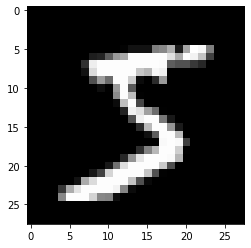

In [13]:
import matplotlib.pyplot as plt

with tf.device("CPU:0"):
    cpu_model = build_model(allow_cudnn_kernel=True)
    cpu_model.set_weights(model.get_weights())
    result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
    print(
        "Predicted result is: %s, target result is: %s" % (result.numpy(), sample_label)
    )
    plt.imshow(sample, cmap=plt.get_cmap("gray"))

## RNNs with list/dict inputs, or nested inputs

Nested structures allow implementers to include more information within a single
timestep. For example, a video frame could have audio and video input at the same
time. The data shape in this case could be:

`[batch, timestep, {"video": [height, width, channel], "audio": [frequency]}]`

In another example, handwriting data could have both coordinates x and y for the
current position of the pen, as well as pressure information. So the data
representation could be:

`[batch, timestep, {"location": [x, y], "pressure": [force]}]`

The following code provides an example of how to build a custom RNN cell that accepts
such structured inputs.

### Define a custom cell that supports nested input/output

See [Making new Layers & Models via subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models/)
for details on writing your own layers.

In [14]:
class NestedCell(keras.layers.Layer):
    def __init__(self, unit_1, unit_2, unit_3, **kwargs):
        self.unit_1 = unit_1
        self.unit_2 = unit_2
        self.unit_3 = unit_3
        self.state_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
        self.output_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
        super(NestedCell, self).__init__(**kwargs)

    def build(self, input_shapes):
        # expect input_shape to contain 2 items, [(batch, i1), (batch, i2, i3)]
        i1 = input_shapes[0][1]
        i2 = input_shapes[1][1]
        i3 = input_shapes[1][2]

        self.kernel_1 = self.add_weight(
            shape=(i1, self.unit_1), initializer="uniform", name="kernel_1"
        )
        self.kernel_2_3 = self.add_weight(
            shape=(i2, i3, self.unit_2, self.unit_3),
            initializer="uniform",
            name="kernel_2_3",
        )

    def call(self, inputs, states):
        # inputs should be in [(batch, input_1), (batch, input_2, input_3)]
        # state should be in shape [(batch, unit_1), (batch, unit_2, unit_3)]
        input_1, input_2 = tf.nest.flatten(inputs)
        s1, s2 = states

        output_1 = tf.matmul(input_1, self.kernel_1)
        output_2_3 = tf.einsum("bij,ijkl->bkl", input_2, self.kernel_2_3)
        state_1 = s1 + output_1
        state_2_3 = s2 + output_2_3

        output = (output_1, output_2_3)
        new_states = (state_1, state_2_3)

        return output, new_states

    def get_config(self):
        return {"unit_1": self.unit_1, "unit_2": unit_2, "unit_3": self.unit_3}


### Build a RNN model with nested input/output

Let's build a Keras model that uses a `keras.layers.RNN` layer and the custom cell
we just defined.

In [15]:
unit_1 = 10
unit_2 = 20
unit_3 = 30

i1 = 32
i2 = 64
i3 = 32
batch_size = 64
num_batches = 10
timestep = 50

cell = NestedCell(unit_1, unit_2, unit_3)
rnn = keras.layers.RNN(cell)

input_1 = keras.Input((None, i1))
input_2 = keras.Input((None, i2, i3))

outputs = rnn((input_1, input_2))

model = keras.models.Model([input_1, input_2], outputs)

model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])

### Train the model with randomly generated data

Since there isn't a good candidate dataset for this model, we use random Numpy data for
demonstration.

In [16]:
input_1_data = np.random.random((batch_size * num_batches, timestep, i1))
input_2_data = np.random.random((batch_size * num_batches, timestep, i2, i3))
target_1_data = np.random.random((batch_size * num_batches, unit_1))
target_2_data = np.random.random((batch_size * num_batches, unit_2, unit_3))
input_data = [input_1_data, input_2_data]
target_data = [target_1_data, target_2_data]

model.fit(input_data, target_data, batch_size=batch_size)

 1/10 [==>...........................] - ETA: 6s - loss: 1.1745 - rnn_1_loss: 0.3000 - rnn_1_1_loss: 0.8745 - rnn_1_accuracy: 0.0312 - rnn_1_1_accuracy: 0.0273

 3/10 [========>.....................] - ETA: 0s - loss: 0.9320 - rnn_1_loss: 0.3024 - rnn_1_1_loss: 0.6297 - rnn_1_accuracy: 0.0885 - rnn_1_1_accuracy: 0.0312

 5/10 [==============>...............] - ETA: 0s - loss: 0.8759 - rnn_1_loss: 0.2955 - rnn_1_1_loss: 0.5804 - rnn_1_accuracy: 0.1063 - rnn_1_1_accuracy: 0.0355

 7/10 [====================>.........] - ETA: 0s - loss: 0.8079 - rnn_1_loss: 0.2825 - rnn_1_1_loss: 0.5254 - rnn_1_accuracy: 0.1049 - rnn_1_1_accuracy: 0.0329

10/10 [==============================] - ETA: 0s - loss: 0.7316 - rnn_1_loss: 0.2590 - rnn_1_1_loss: 0.4725 - rnn_1_accuracy: 0.1016 - rnn_1_1_accuracy: 0.0328

10/10 [==============================] - 1s 26ms/step - loss: 0.7316 - rnn_1_loss: 0.2590 - rnn_1_1_loss: 0.4725 - rnn_1_accuracy: 0.1016 - rnn_1_1_accuracy: 0.0328


With the Keras `keras.layers.RNN` layer, You are only expected to define the math
logic for individual step within the sequence, and the `keras.layers.RNN` layer
will handle the sequence iteration for you. It's an incredibly powerful way to quickly
prototype new kinds of RNNs (e.g. a LSTM variant).

For more details, please visit the [API docs](https://https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN/).